# BirdCLEF 2023 🐦
> Identify bird calls in soundscapes

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/44224/logos/header.png?t=2023-03-06-18-30-53">

# Methodology  🎯
* This notebook will demonstrate **Bird Call Identification** with `TensorFlow`. 
* This notebook will also show how to infer using `TensorFlow`. For training check below mentioned notebook.
* This notebook will use `5sec` audio recording as per requirements. But training is done on much more larger size recording. Dynamic shape is utilize to infer on a different resolution.
* This notebook will consider one recording as one batch which will speed up the processing.

# Notebooks 📓

* EffNet + FSR + CutMixUp
    * Train: [BirdCLEF23: EffNet + FSR + CutMixUp [Train]](https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-train/edit)
    * Infer: [BirdCLEF23: EffNet + FSR + CutMixUp [Infer]](https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-infer/edit)


# Update 🆕
* `v3`:
    * Creates batch spectrogram w/o using map function
    * Loads all ckpts to memory to reduce bottleneck
    * Fixed prediction dtype = `object`.
* `v7`:
    * upsampe + cv_filter
    * effnetb0 + fsr
* `v9`: (Bug)!
    * train duration: 10 sec
    * spec shape: 128 x 384
* `v10`:
    * Fix for `v9`
    * MinMax normalization
    * 10 sec recording in train
    * spec shape 128 x 384

# Install Libraries 🛠

In [1]:
import sys, os
sys.path.append('/kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle')

# Import Libraries 📚

In [2]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)
import os
import pandas as pd
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()
import gc
import librosa
import sklearn
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd

import tensorflow as tf
tf.config.optimizer.set_jit(True) # enable xla for speed up
import tensorflow_io as tfio
import tensorflow.keras.backend as K

import efficientnet.tfkeras as efn

## Library Version

In [3]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('librosa:', librosa.__version__)
print('tf:', tf.__version__)
print('tfio:', tfio.__version__)

np: 1.21.6
pd: 1.3.5
sklearn: 1.0.2
librosa: 0.10.0
tf: 2.11.0
tfio: 0.29.0


# Configuration ⚙️

In [4]:
class CFG:
    debug = False
    verbose = 0
    
    device = 'CPU'
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 16
    infer_bs = 2
    tta = 1
    drop_remainder = True
    
    # STFT parameters
    duration = 5 # duration for test
    train_duration = 10
    sample_rate = 32000
    downsample = 1
    trim = True
    audio_len = duration*sample_rate
    nfft = 2028
    window = 2048
    hop_length = train_duration*32000 // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True

    # Data Preprocessing Settings
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2023/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}
    
    target_col = ['target']
    tab_cols = ['filename','common_name','rate']

# Reproducibility ♻️
Sets value for random seed to produce similar result in each run.

In [5]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# Set Up Device  📱
Following codes automatically detects hardware(tpu or tpu-vm or gpu). 

In [6]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if CFG.device=='TPU-VM' else None
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu) 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on {CFG.device} ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu

In [7]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device, tpu = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on CPU


# Dataset Path 📁

In [8]:
BASE_PATH = '/kaggle/input/birdclef-2023'
GCS_PATH = BASE_PATH

# Meta Data 📖
* **test_soundscapes/** - directory contains $~200$ recordings to be used for scoring when a notebook is submitted. Without submission only $1$ recording is accessible.  All recordings are $10$ minutes long and in `.ogg` audio format.
* **sample_submission.csv** - is the valid sample submission.
    * `row_id`: A slug of [soundscape_id]_[end_time] for the prediction.
    * `[bird_id]`: There are $264$ bird ID columns. The probability of the presence of each bird for each row needs to be predicted.

In [9]:
test_paths = glob('/kaggle/input/birdclef-2023/test_soundscapes/*ogg')
test_df = pd.DataFrame(test_paths, columns=['filepath'])
test_df['filename'] = test_df.filepath.map(lambda x: x.split('/')[-1].replace('.ogg',''))
test_df.head()

,filepath,filename
0,/kaggle/input/birdclef-2023/test_soundscapes/s...,soundscape_29201


In [10]:
tf.io.gfile.exists(test_df.filepath.iloc[0])

True

# Data Loader 🍚

In [11]:
def load_audio(filepath, sr=32000, normalize=True):
    audio, orig_sr = librosa.load(filepath, sr=None)
    if sr!=orig_sr:
        audio = librosa.resample(y, orig_sr, sr)
    audio = audio.astype('float32').ravel()
    audio = tf.convert_to_tensor(audio)
    if normalize:
        audio = Normalize(audio)
    return audio

# @tf.function
# def load_audio_tf(filepath, normalize=True):
#     file_bytes = tf.io.read_file(filepath)
#     audio = tfio.audio.decode_vorbis(file_bytes)
# #     audio = tf.cast(audio_file.to_tensor, tf.float32)
#     audio = tf.squeeze(audio, axis=-1)
#     if normalize:
#         audio = Normalize(audio)
#     return audio

# Standardize the audio
@tf.function(jit_compile=True)
def Normalize(data, min_max=True):
    # Compute the mean and standard deviation of the data
    MEAN = tf.math.reduce_mean(data)
    STD = tf.math.reduce_std(data)
    # Standardize the data
    data = tf.math.divide_no_nan(data - MEAN, STD)
    # Normalize to [0, 1]
    if min_max:
        MIN = tf.math.reduce_min(data)
        MAX = tf.math.reduce_max(data)
        data = tf.math.divide_no_nan(data - MIN, MAX - MIN)
    return data

@tf.function(jit_compile=True)
def Spec2Img(spec):
    spec = tf.tile(spec[..., tf.newaxis], [1, 1, 1, 3])
    return spec

@tf.function(jit_compile=True)
def Img2Spec(img):
    return img[..., 0]

@tf.function(jit_compile=True)
def MakeFrame(audio, duration=5, sr=32000):
    frame_length = int(duration * sr)
    frame_step = int(duration * sr)
    chunks = tf.signal.frame(audio, frame_length, frame_step, pad_end=True)
    return chunks

@tf.function(jit_compile=True)
def Audio2Spec(audio, spec_shape = CFG.img_size, sr=CFG.sample_rate, 
                    nfft=CFG.nfft, window=CFG.window, fmin=CFG.fmin, fmax=CFG.fmax, return_img=True):
    spec_height = spec_shape[0]
    spec_width = spec_shape[1]
    hop_length = tf.cast(CFG.hop_length, tf.int32) # sample rate * duration / spec width - 1 == 627
    spec = tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=hop_length)
    mel_spec = tfio.audio.melscale(spec, rate=sr, mels=spec_height, fmin=fmin, fmax=fmax)
    db_mel_spec = tfio.audio.dbscale(mel_spec, top_db=80)
    db_mel_spec = tf.linalg.matrix_transpose(db_mel_spec) # to keep it (batch, mel, time)
    return db_mel_spec

# EDA 🎨

## Utility

In [12]:
def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename}'
    # Read audio file
    audio = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = Audio2Spec(audio, return_img=False)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio.numpy(), rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio.numpy(),
                 sr=CFG.sample_rate,
                 ax=ax[0])
    # Specplot
    lid.specshow(spec.numpy(), 
                 sr = CFG.sample_rate, 
                 hop_length = CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Check

# Audio:


# Visualization:


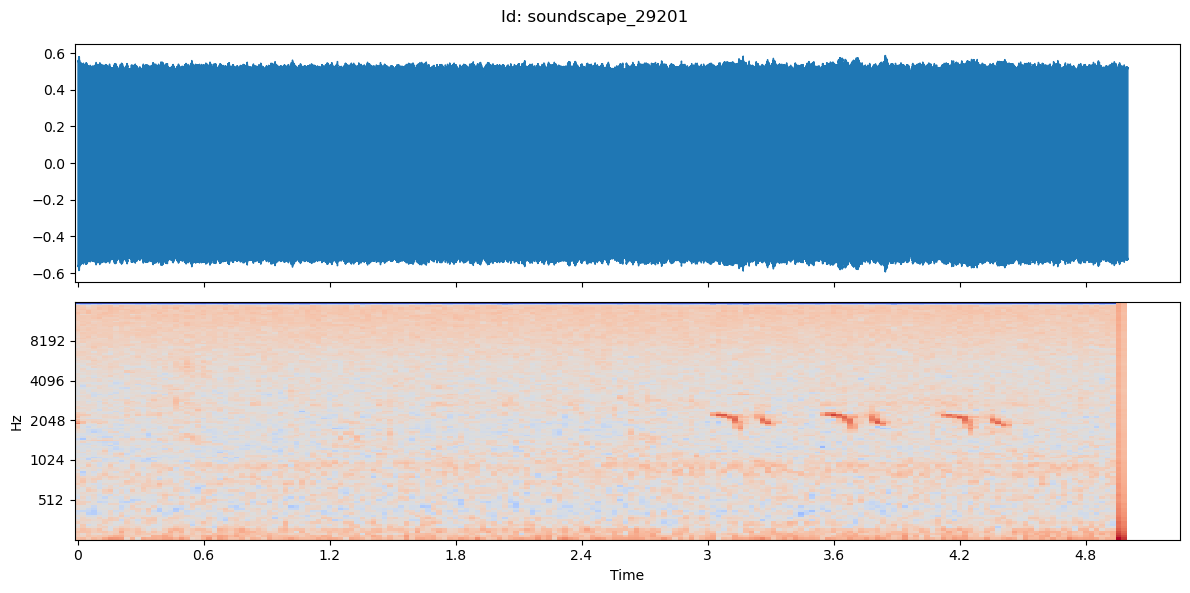

In [13]:
display_audio(test_df.iloc[0])

# Inference Configs 🔧

In [14]:
# Directory of checkpoint
CKPT_DIR = '/kaggle/input/birdclef23-effnet-fsr-cutmixup-train-ds'
# Get file paths of all trained models in the directory
CKPT_PATHS = sorted(glob(f'{CKPT_DIR}/*h5'))
# Load all the models in memory to speed up
CKPTS = [tf.keras.models.load_model(x, compile=False) for x in tqdm(CKPT_PATHS, desc="Loading ckpts ")]
# Num of ckpt to use
NUM_CKPTS = 1

# Submit or Interactive mode
SUBMIT = pd.read_csv('/kaggle/input/birdclef-2023/sample_submission.csv').shape[0] != 3

Loading ckpts : 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


# Inference 🧪

In [15]:
# Start stopwatch
tick = time.time()

# Initialize empty list to store ids
ids = []
# Initialize empty array to store predictions
preds = np.empty(shape=(0, 264), dtype='float32')

# Iterate over each audio file in the test dataset
for filepath in tqdm(test_df.filepath.tolist(), 'test '):
    # Extract the filename without the extension
    filename = filepath.split('/')[-1].replace('.ogg','')
    
    # Load audio from file and create audio frames, each recording will be a batch input
    audio = load_audio(filepath)
    chunks = MakeFrame(audio)
    
#     # If not submitting, only use the first three frames for speed
#     if not SUBMIT:
#         chunks = chunks[:3]
    
    # Convert audio frames to spectrograms + rgb image using a vectorized function 
    specs = Audio2Spec(chunks)
    specs = Spec2Img(specs)
    
    # Predict bird species for all frames in a recording using all trained models
    chunk_preds = np.zeros(shape=(len(specs), 264), dtype=np.float32)
    for model in CKPTS[:NUM_CKPTS]:
        # Get the model's predictions for the current audio frames
        rec_preds = model(specs, training=False).numpy()
        # Ensemble all prediction with average
        chunk_preds += rec_preds/len(CKPTS)
    
    # Create a ID for each frame in a recording using the filename and frame number
    rec_ids = [f'{filename}_{(frame_id+1)*5}' for frame_id in range(len(chunks))]
    
    # Concatenate the ids
    ids += rec_ids
    # Concatenate the predictions
    preds = np.concatenate([preds, chunk_preds], axis=0)
    
# Stop stopwatch
tock = time.time()

test : 100%|██████████| 1/1 [00:34<00:00, 34.42s/it]


# Submission 📮

In [16]:
# Submit prediction
pred_df = pd.DataFrame(ids, columns=['row_id'])
pred_df.loc[:, CFG.class_names] = preds
pred_df.to_csv('submission.csv',index=False)
pred_df.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0.003144,0.001071,0.000350,0.000417,0.000560,0.000435,0.006618,0.000946,0.006162,...,0.000532,0.000213,0.000232,0.001625,0.000493,0.001379,0.000328,0.000352,0.000431,0.000781
1,soundscape_29201_10,0.005309,0.005349,0.002287,0.005360,0.000666,0.000874,0.004176,0.000321,0.001583,...,0.001060,0.000893,0.005252,0.026125,0.000403,0.004089,0.000475,0.000980,0.000250,0.001593
2,soundscape_29201_15,0.001525,0.002415,0.000372,0.001905,0.000269,0.004452,0.000106,0.000046,0.000505,...,0.001092,0.000787,0.000342,0.004905,0.000870,0.000570,0.000257,0.004789,0.006486,0.004501
3,soundscape_29201_20,0.000214,0.001183,0.002668,0.000702,0.003419,0.000261,0.000393,0.001042,0.000746,...,0.000796,0.016386,0.001476,0.003247,0.001692,0.002267,0.000441,0.002558,0.000516,0.000904
4,soundscape_29201_25,0.000392,0.000912,0.003645,0.002201,0.001551,0.000448,0.000285,0.000330,0.000286,...,0.000478,0.006794,0.000199,0.003233,0.000900,0.001865,0.000776,0.000835,0.000639,0.000780


## Check Submission

In [17]:
if not SUBMIT:
    pred_labels = pred_df[pred_df.columns[1:]].values.argmax(axis=1)
    pred_classes = list(map(lambda x: CFG.label2name[x], pred_labels))
    print(pred_classes)

['woosan', 'litegr', 'pabspa1', 'thrnig1', 'pygbat1', 'pygbat1', 'eaywag1', 'pygbat1', 'pygbat1', 'combuz1', 'eaywag1', 'rewsta1', 'rewsta1', 'eubeat1', 'loceag1', 'loceag1', 'wlwwar', 'somtit4', 'afghor1', 'mouwag1', 'blnmou1', 'rbsrob1', 'afghor1', 'combuz1', 'combuz1', 'combuz1', 'combuz1', 'combuz1', 'afghor1', 'brican1', 'blbpuf2', 'thrnig1', 'afghor1', 'raybar1', 'raybar1', 'raybar1', 'raybar1', 'woosan', 'pygbat1', 'pygbat1', 'pygbat1', 'eaywag1', 'wlwwar', 'thrnig1', 'thrnig1', 'barswa', 'rebfir2', 'meypar1', 'brican1', 'brican1', 'brican1', 'rbsrob1', 'carcha1', 'somgre1', 'wbrcha2', 'pygbat1', 'litegr', 'amesun2', 'eaywag1', 'afbfly1', 'wlwwar', 'hoopoe', 'cohmar1', 'klacuc1', 'grbcam1', 'pygbat1', 'pygbat1', 'wlwwar', 'combuz1', 'gyhbus1', 'lawgol', 'pygbat1', 'pygbat1', 'pygbat1', 'pygbat1', 'pygbat1', 'pygbat1', 'pygbat1', 'combuz1', 'wlwwar', 'ruegls1', 'palpri1', 'rebfir2', 'rebfir2', 'pygbat1', 'lawgol', 'pygbat1', 'pygbat1', 'pygbat1', 'pygbat1', 'pygbat1', 'comsan', '

# Submission Time ⏰
Estimated time to complete the submission.
> **Note**: There are nearly ~$200$ recordings on the test data.

In [18]:
sub_time = (tock-tick)*200 # ~200 recording on the test data
sub_time = time.gmtime(sub_time)
sub_time = time.strftime("%H hr: %M min : %S sec", sub_time)
print(f">> Time for submission: ~ {sub_time}")

>> Time for submission: ~ 01 hr: 54 min : 45 sec
